In [ ]:
%cd /content/drive/MyDrive/KTH/course/gpu

/content/drive/MyDrive/KTH/course/gpu


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-8vlrelx_
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-8vlrelx_
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=3da5ebc8d902ef056c9e451e2be72452a640f91b78f1005955076023ab2df80a
  Stored in directory: /tmp/pip-ephem-wheel-cache-iqa3u9b2/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

directory /content/drive/MyDrive/KTH/course/gpu/src already exists
Out bin /content/drive/MyDrive/KTH/course/gpu/result.out


In [ ]:
%%cuda --name lab3_ex1.cu 

#include <stdio.h>
#include <sys/time.h>

#define DataType double

__global__ void vecAdd(DataType *in1, DataType *in2, DataType *out, int len) {
  //@@ Insert code to implement vector addition here
  // Get our global thread ID
  const int idx = blockIdx.x*blockDim.x+threadIdx.x;
  // Make sure we do not go out of bounds
  if (idx < len)
      out[idx] = in1[idx] + in2[idx];
}

//@@ Insert code to implement timer start
void timeStart(struct timeval *startt)
{
  gettimeofday(startt,NULL);
}

//@@ Insert code to implement timer stop
void timeStop(struct timeval *startt)
{
  struct timeval stopt;
  float timet;
  //printf("%f", startt->tv_usec*1.0e-6);
  gettimeofday(&stopt,NULL);
  timet = (stopt.tv_usec-startt->tv_usec)*1.0e-6 + stopt.tv_sec - startt->tv_sec;
  printf("Time: %f (s)\n",timet);
}


int main(int argc, char **argv) {
  
  int inputLength;
  DataType *hostInput1;
  DataType *hostInput2;
  DataType *hostOutput;
  DataType *resultRef;
  DataType *deviceInput1;
  DataType *deviceInput2;
  DataType *deviceOutput;

  //@@ Insert code below to read in inputLength from args
  sscanf(argv[1],"%d",&inputLength);

  printf("The input length is %d\n", inputLength);
  
  //@@ Insert code below to allocate Host memory for input and output
  hostInput1 = (DataType *)malloc(inputLength*sizeof(DataType));
  hostInput2 = (DataType *)malloc(inputLength*sizeof(DataType));
  hostOutput = (DataType *)malloc(inputLength*sizeof(DataType));
  resultRef = (DataType *)malloc(inputLength*sizeof(DataType));

  //@@ Insert code below to initialize hostInput1 and hostInput2 to random numbers, and create reference result in CPU
  for (int i = 0; i < inputLength; i++)
  {
    hostInput1[i] = (double) rand() / RAND_MAX;
    hostInput2[i] = (double) rand() / RAND_MAX;
    resultRef[i] = hostInput1[i] + hostInput2[i];
  }

  //@@ Insert code below to allocate GPU memory here
  cudaMalloc(&deviceInput1, inputLength*sizeof(DataType));
  cudaMalloc(&deviceInput2, inputLength*sizeof(DataType));
  cudaMalloc(&deviceOutput, inputLength*sizeof(DataType));

  //@@ Insert code to below to Copy memory to the GPU here
  struct timeval timeh2d;
  timeStart(&timeh2d);
  cudaMemcpy(deviceInput1, hostInput1, inputLength*sizeof(DataType), cudaMemcpyHostToDevice);
  cudaMemcpy(deviceInput2, hostInput2, inputLength*sizeof(DataType), cudaMemcpyHostToDevice);
  printf("H2D: ");
  timeStop(&timeh2d);

  //@@ Initialize the 1D grid and block dimensions here
  int blockSize, gridSize;
  blockSize = 1024; // set this value
  gridSize = (int)ceil((float)inputLength/blockSize);

  //@@ Launch the GPU Kernel here
  struct timeval timekernel;
  timeStart(&timekernel);
  vecAdd<<<gridSize, blockSize>>>(deviceInput1, deviceInput2, deviceOutput, inputLength);
  cudaDeviceSynchronize();
  printf("Kernel: ");
  timeStop(&timekernel);

  //@@ Copy the GPU memory back to the CPU here
  struct timeval timed2h;
  timeStart(&timed2h);
  cudaMemcpy( hostOutput, deviceOutput, inputLength*sizeof(DataType), cudaMemcpyDeviceToHost );
  printf("D2H: ");
  timeStop(&timed2h);

  //@@ Insert code below to compare the output with the reference
  for (int i = 0; i < inputLength; i++)
  {
    //printf("resultRef[i]= %.3f", resultRef[i]);
    //printf("hostOutput[i]= %.3f", hostOutput[i]);
    if (resultRef[i] != hostOutput[i])
      printf("resultRef[i]= %.3f, hostOutput[i]= %.3f", resultRef[i], hostOutput[i]);
  }

  //@@ Free the GPU memory here
  cudaFree(deviceInput1);
  cudaFree(deviceInput2);
  cudaFree(deviceOutput);

  //@@ Free the CPU memory here
  free(hostInput1);
  free(hostInput2);
  free(hostOutput);
  free(resultRef);
  printf("===========================================\n");
  return 0;
}



'File written in /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex1.cu'

In [ ]:
!nvcc -o /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex1 /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex1.cu 

In [ ]:
! /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex1 1024

The input length is 1024
H2D: Time: 0.000033 (s)
Kernel: Time: 0.000041 (s)
D2H: Time: 0.000027 (s)


In [ ]:
! /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex1 131070

The input length is 131070
H2D: Time: 0.000584 (s)
Kernel: Time: 0.000021 (s)
D2H: Time: 0.000868 (s)


In [ ]:
%%shell 
#!/bin/bash
for VARIABLE in 128 256 1024 4096 16384 65536 131070 262144 1048576
do
    ! /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex1 $VARIABLE
done  

The input length is 128
H2D: Time: 0.000025 (s)
Kernel: Time: 0.000016 (s)
D2H: Time: 0.000019 (s)
The input length is 256
H2D: Time: 0.000026 (s)
Kernel: Time: 0.000020 (s)
D2H: Time: 0.000019 (s)
The input length is 1024
H2D: Time: 0.000035 (s)
Kernel: Time: 0.000017 (s)
D2H: Time: 0.000025 (s)
The input length is 4096
H2D: Time: 0.000074 (s)
Kernel: Time: 0.000016 (s)
D2H: Time: 0.000058 (s)
The input length is 16384
H2D: Time: 0.000111 (s)
Kernel: Time: 0.000015 (s)
D2H: Time: 0.000114 (s)
The input length is 65536
H2D: Time: 0.000284 (s)
Kernel: Time: 0.000020 (s)
D2H: Time: 0.000402 (s)
The input length is 131070
H2D: Time: 0.000581 (s)
Kernel: Time: 0.000020 (s)
D2H: Time: 0.000813 (s)
The input length is 262144
H2D: Time: 0.001012 (s)
Kernel: Time: 0.000020 (s)
D2H: Time: 0.001496 (s)
The input length is 1048576
H2D: Time: 0.003727 (s)
Kernel: Time: 0.000021 (s)
D2H: Time: 0.005704 (s)


CalledProcessError: ignored

In [ ]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex1 131070

The input length is 131070
==PROF== Connected to process 630 (/content/drive/MyDrive/KTH/course/gpu/src/lab3_ex1)
H2D: Time: 0.000565 (s)
==PROF== Profiling "vecAdd" - 1: 0%....50%....100% - 8 passes
Kernel: Time: 0.645067 (s)
D2H: Time: 0.000765 (s)
==PROF== Disconnected from process 630
[630] lab3_ex1@127.0.0.1
  vecAdd(double*, double*, double*, int), 2022-Dec-12 15:40:09, Context 1, Stream 7
    Section: GPU Speed Of Light
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                                                           cycle/nsecond                           4.92
    SM Frequency                                                             cycle/usecond                         578.25
    Elapsed Cycles                                                                   cycle                          8,374
    Memory [%]                                                                   

In [ ]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex1 1024

The input length is 1024
==PROF== Connected to process 652 (/content/drive/MyDrive/KTH/course/gpu/src/lab3_ex1)
H2D: Time: 0.000049 (s)
==PROF== Profiling "vecAdd" - 1: 0%....50%....100% - 8 passes
Kernel: Time: 0.647192 (s)
D2H: Time: 0.000049 (s)
==PROF== Disconnected from process 652
[652] lab3_ex1@127.0.0.1
  vecAdd(double*, double*, double*, int), 2022-Dec-12 15:40:21, Context 1, Stream 7
    Section: GPU Speed Of Light
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                                                           cycle/nsecond                           4.88
    SM Frequency                                                             cycle/usecond                         571.80
    Elapsed Cycles                                                                   cycle                          3,002
    Memory [%]                                                                     

Text(0, 0.5, 'Time (s)')

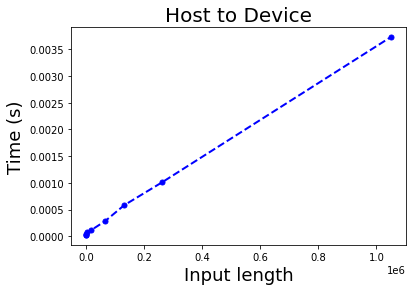

In [ ]:
import matplotlib.pyplot as plt

plt.plot([128, 256, 1024, 4096, 16384, 65536, 131070, 262144, 1048576],[0.000025, 0.000026, 0.000035, 0.000074, 0.000111, 0.000284, 0.000581, 0.001012, 0.003727], 'bo--', linewidth=2, markersize=5)
plt.title('Host to Device', fontsize=20)
plt.xlabel('Input length', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

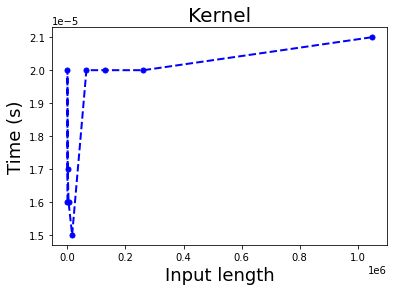

In [ ]:
import matplotlib.pyplot as plt

plt.plot([128, 256, 1024, 4096, 16384, 65536, 131070, 262144, 1048576],[0.000016, 0.000020, 0.000017, 0.000016, 0.000015, 0.000020, 0.000020, 0.000020, 0.000021], 'bo--', linewidth=2, markersize=5)
plt.title('Kernel', fontsize=20)
plt.xlabel('Input length', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

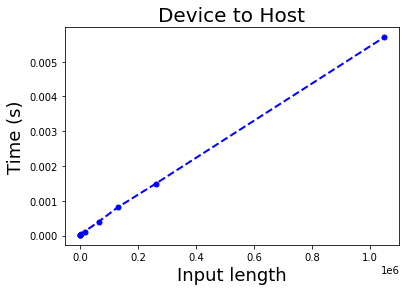

In [ ]:
import matplotlib.pyplot as plt

plt.plot([128, 256, 1024, 4096, 16384, 65536, 131070, 262144, 1048576],[0.000019, 0.000019, 0.000025, 0.000058, 0.000114, 0.000402, 0.000813, 0.001496, 0.005704], 'bo--', linewidth=2, markersize=5)
plt.title('Device to Host', fontsize=20)
plt.xlabel('Input length', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)